In This Notebook: 
 - determining new step in ra 
 - distance calculation with new step
 - new inside cut (extended to higher ra values) 
 - parallax offset calculation 

In [1]:
import pylab as plt
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import math
import astropy.io.fits as fits
from astropy.table import Table, Column 
import utils

In [2]:
def sphdist(lon1, lat1, lon2, lat2):
    """Calculate the angular distance between two sets of points.

    Parameters
    ----------
    lon1/lat1 : scalar or array_like
        first dataset, arrays of LON/LAT or RA/DEC
        both measured in degrees
    lon2/lat2 : scalar array_like
        second dataset, arrays of LON/LAT or RA/DEC
        both measured in degrees

    Returns
    -------
    dist: ndarrays
        The angular distance in degrees.
    """

    if (np.size(lon1) != np.size(lat1)):
        raise ValueError('lon1/lat1 must have same number of elements')
    if (np.size(lon2) != np.size(lat2)):
        raise ValueError('lon2/lat2 must have same number of elements')    

    cosa = np.sin(np.deg2rad(lat1))*np.sin(np.deg2rad(lat2))+np.cos(np.deg2rad(lat1))*np.cos(np.deg2rad(lat2))*np.cos(np.deg2rad(lon1-lon2))
    dist = np.rad2deg(np.arccos(cosa))

    return dist

In [3]:
df = fits.getdata('LMC_EDR3_wo_cuts.fits')

In [4]:
dec = []
ra_step = []

ra = 60

for j in range (26):
    y = j - 80
    r = sphdist(ra, y, df['ra'], df['dec'])
    res = np.where(r <= 0.5)
    ra_s = np.max(df['ra'][res]) - ra
    dec.append(y)
    ra_step.append(ra_s)

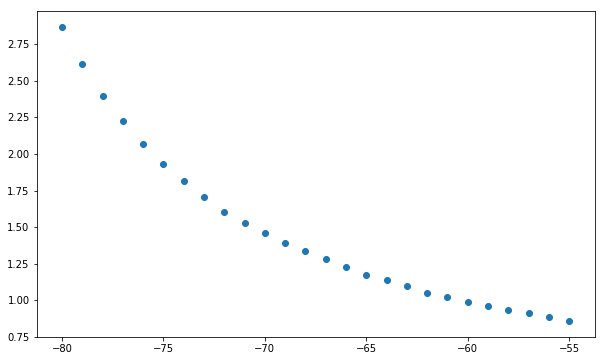

In [5]:
plt.figure(figsize=(10,6))
plt.scatter(dec, ra_step)

In [6]:
ra_step[0]

2.868616550953149

In [9]:
def roi_cut(xcut,ycut,x,y): 
    from matplotlib.path import Path
    tupVerts = list(zip(xcut,ycut))
    points = np.vstack((x,y)).T
    p = Path(tupVerts) # make a polygon
    inside = p.contains_points(points)
    ind, = np.where(~inside)
    cutind, = np.where(inside)
    return ind, cutind
    print (ind, cutind)

In [10]:
## RGB cmd cut

def LMCParallax(df, ra, dec, radius=0.3):
    r = sphdist(ra, dec, df['ra'], df['dec'])
    res = np.where(r <= radius)
    df = df[res]
    xcut = [0.738710, 1.077419, 1.512903, 1.68, 2.035484, 2.4, 2.432258, 1.929032, 1.764516, 1.45, 0.7]
    ycut = [19.346753, 19.9, 19.441558, 18, 16.5, 16.1, 15.85, 15.487013, 15.603896, 16, 18.75]
    x = df['bp_rp']
    y = df['phot_g_mean_mag']
    (ind, cutind) = roi_cut(xcut,ycut,x,y)
    df = df[cutind]
    medpmra = np.nanmedian(df['pmra'])
    medpmdec = np.nanmedian(df['pmdec'])
    pndist = np.sqrt((df['pmra']-medpmra)**2 + (df['pmdec']-medpmdec)**2)
    good = (abs(df['parallax']) < 3*df['parallax_error']) & (pndist<=2.0)
    medplx = np.nanmedian(df['parallax'][good]) 
    ngood = np.sum(good)
    sigma= (1/ngood)*np.sqrt(np.nansum((df['parallax_error'][good])**2)) #standard error of parallax
    return (ngood, medplx, sigma)


In [11]:
dtype = np.dtype([('ra',float),('dec',float)])
cat = np.zeros([64,26],dtype=dtype)
for j in range (26):
    dec = j - 80
    for i in range (64):
        ra = ra_step[j]*i + 55
        if ra <= 110:
            cat[i,j]['ra']=ra
            cat[i,j]['dec']=dec

(-81, -54)

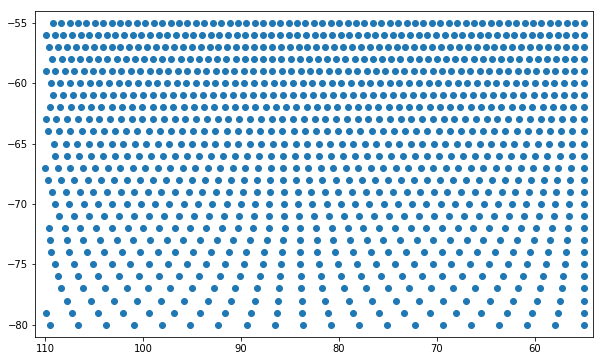

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(cat['ra'], cat['dec'])
plt.xlim(111,54)
plt.ylim(-81,-54)

In [13]:
## distance calculation with the RGB cmd cut, 1 deg steps, 0.5 deg radius

dtype = np.dtype([('ra',float),('dec',float),('ngood',int),('parallax',float),('sigma',float)])
cat = np.zeros([56,26],dtype=dtype)
for j in range (26):
    dec = j - 80
    for i in range (56):
        ra = ra_step[j]*i + 55
        if ra <= 110:
            (ngood, medplx, sigma) = LMCParallax(df,ra,dec,radius=0.5) 
            cat[i,j]['ra']=ra
            cat[i,j]['dec']=dec
            cat[i,j]['ngood']=ngood
            cat[i,j]['parallax']=medplx
            cat[i,j]['sigma']=sigma
        
acat = Table(cat)
acat.write('LMC_EDR3_dist6.fits', format='fits')

KeyboardInterrupt: 

In [14]:
acat = Table(fits.getdata('LMC_EDR3_dist6.fits'))

(-81, -54)

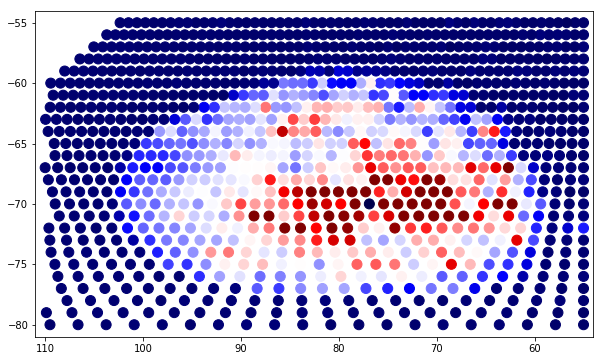

In [20]:
plt.figure(figsize=(10,6))
plt.scatter(acat['ra'], acat['dec'], c=1/(acat['parallax']+0.02), s=100, vmin=0, vmax=100, cmap=plt.cm.seismic)
plt.xlim(111,54)
plt.ylim(-81,-54)

In [21]:
xcut = [102.163978, 97.506720, 91.962366, 84.939516, 74.294355, 68.158602, 61.801075, 60.692204, 60.618280, 63.131720, 66.975806, 75.698925, 84.274194, 90.557796, 98.467742, 102.163978]
ycut = [-67.067100, -63.603896, -61.493506, -60.357143, -59.870130, -61.655844, -66.309524, -71.179654, -73.290043, -75.183983, -76.536797, -77.510823, -77.294372, -76.969697, -74.642857, -71.720779]
x = acat['ra'].ravel()
y = acat['dec'].ravel()

(ind, cutind) = roi_cut(xcut,ycut,x,y)


In [32]:
xcut2 = [78.877688, 83.830645, 90.1, 90.2, 83.534946, 77.990591, 74.737903, 68.750000, 66.606183, 70.524194, 75.403226]
ycut2 = [-68.095238, -68.311688, -69.9, -71.1, -73.452381, -72.424242, -72.099567, -72.099567, -70.205628, -67.662338, -67.229437]
x2 = acat['ra'].ravel()[cutind]
y2 = acat['dec'].ravel()[cutind]

(ind2, cutind2) = roi_cut(xcut2,ycut2,x2,y2)


In [33]:
cut2 = []
for i in range(len(xcut2)):
    cut2.append([xcut2[i], ycut2[i]])

In [34]:
cut2.append(cut2[0])
x2, y2 = zip(*cut2)

(-81, -54)

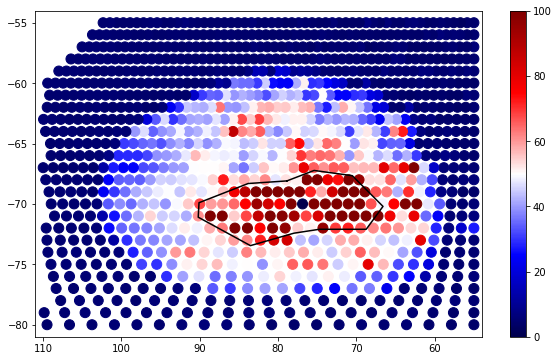

In [35]:
plt.figure(figsize=(10,6))
plt.scatter(acat['ra'], acat['dec'], c=1/(acat['parallax']+0.02), s=100, vmin=0, vmax=100, cmap=plt.cm.seismic)
plt.colorbar()
plt.plot(x2,y2,c='black')
plt.xlim(111,54)
plt.ylim(-81,-54)

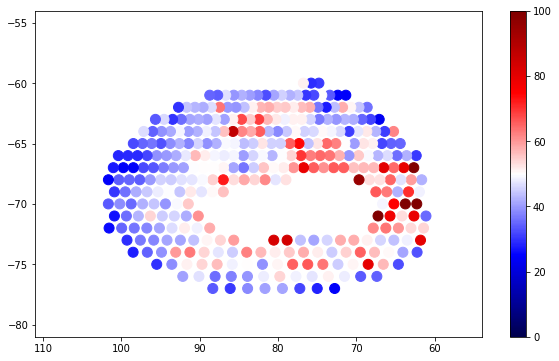

In [37]:
plt.figure(figsize=(10,6))
plt.scatter(acat['ra'].ravel()[cutind][ind2], acat['dec'].ravel()[cutind][ind2], c=1/(acat['parallax'].ravel()[cutind][ind2]+0.02), s=100, vmin=0, vmax=100, cmap=plt.cm.seismic)
plt.xlim(111,54)
plt.ylim(-81,-54)
plt.colorbar()

In [96]:
np.mean(1/(acat['parallax'].ravel()[cutind][ind2] + 0.01935266))

49.89999428029383

In [97]:
acat['parallax'] = acat['parallax'] + 0.01935266
acat['dist'] = 1/acat['parallax']

(-81, -54)

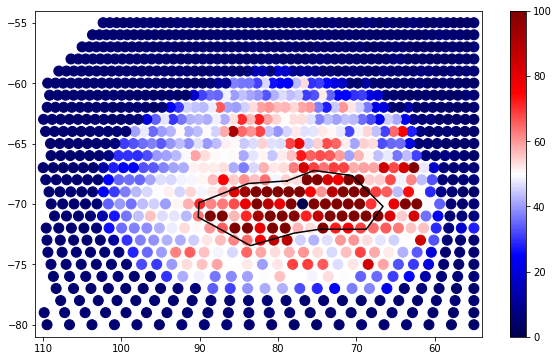

In [98]:
plt.figure(figsize=(10,6))
plt.scatter(acat['ra'], acat['dec'], c=acat['dist'], s=100, vmin=0, vmax=100, cmap=plt.cm.seismic)
plt.colorbar()
plt.plot(x2,y2,c='black')
plt.xlim(111,54)
plt.ylim(-81,-54)

In [99]:
from coords import rotsphcen
from astropy.coordinates import SkyCoord, Longitude

In [100]:
c = SkyCoord(ra=acat['ra'], dec=acat['dec'], frame='icrs', unit='deg')

In [101]:
l = Column(name='Longitude', data=c.galactic.l)
b = Column(name='Latitude', data=c.galactic.b)

In [102]:
acat.add_column(l)
acat.add_column(b)

In [103]:
cen = SkyCoord(ra=82.25, dec=-69.5, frame='icrs', unit='deg')
clon = np.array(cen.galactic.l)
clat = np.array(cen.galactic.b)

In [104]:
nlon, nlat = rotsphcen(acat['Longitude'], acat['Latitude'], clon, clat)

Text(0.5,1,'Distance from Gaia Parallax (RGB cut) [kpc]')

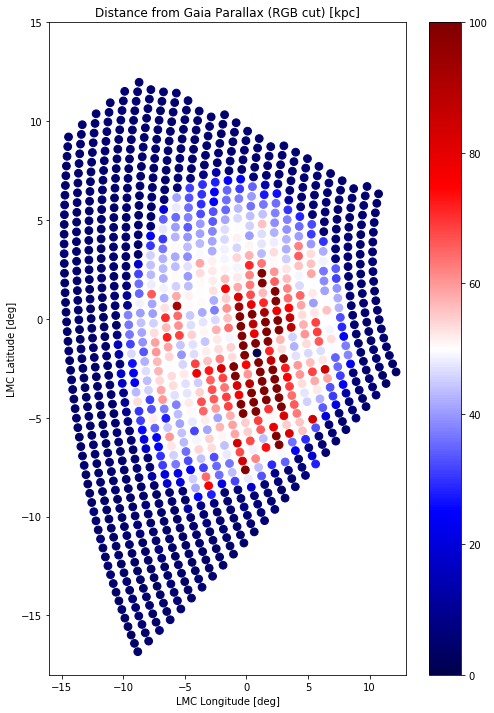

In [108]:
plt.figure(figsize=(8,12))
plt.scatter(nlon, nlat, c=acat['dist'], s=60, vmin=0, vmax=100, cmap=plt.cm.seismic)
plt.colorbar()
plt.xlim([-16,13])
plt.ylim([-18,15])
plt.xlabel('LMC Longitude [deg]')
plt.ylabel('LMC Latitude [deg]')
plt.title('Distance from Gaia Parallax (RGB cut) [kpc]')


In [109]:
## what are the axes for the plots since we're in a LMC centric coordinate system 

In [110]:
nc = SkyCoord(l=nlon, b=nlat, frame='galactic', unit='deg')

In [111]:
nra = np.array(nc.icrs.ra)
ndec = np.array(nc.icrs.dec)

Text(0.5,1,'Distance from Gaia Parallax (RGB cut) [kpc]')

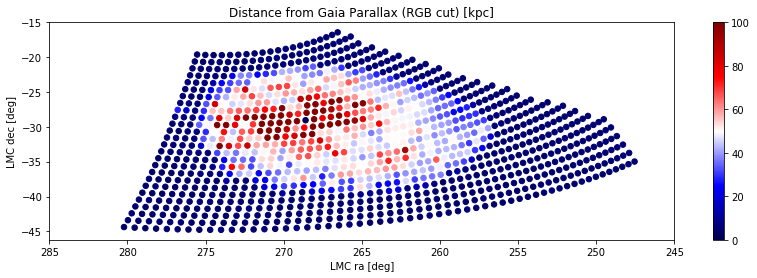

In [118]:
plt.figure(figsize=(14,4))
plt.scatter(nra, ndec, c=acat['dist'], s=30, vmin=0, vmax=100, cmap=plt.cm.seismic)
plt.colorbar()
plt.xlim(285,245)
plt.xlabel('LMC ra [deg]')
plt.ylabel('LMC dec [deg]')
plt.title('Distance from Gaia Parallax (RGB cut) [kpc]')
